In [30]:
#libraries
library(pracma)
library(ggplot2)
library(maps) 
#user functions
source('R_lib/regression/inla/regression_inla_model1_unbounded_hyp.R')

In [31]:
#regression name
reg_name  <- 'SD_regression_ds1_inla'

#regression dataset
flatfile_fname <- 'data/new_SD_PGA.csv'

#output directory
dir_out <- 'data/SD_ds1_inla/'

#INLA regression parameters
runinla_flag <- TRUE # TRUE or FALSE
res_name     <- 'PGA'
#res_name <- 'tot'
#mesh coarseness
# #fine
# mesh_edge_max     <- 5
# mesh_inner_offset <- 15
# mesh_outer_offset <- 15
# #medium
# mesh_edge_max     <- 15
# mesh_inner_offset <- 15
# mesh_outer_offset <- 50
#coarse
mesh_edge_max     <- 50
mesh_inner_offset <- 50
mesh_outer_offset <- 150

#approximation options
# if flag_gp_approx=TRUE uses int.strategy="eb" and strategy="gaussian"
# int.strategy="eb" corresponds to one integration point, and 
# strategy="gaussian" approximates posteriors as gaussian distributions
flag_gp_approx <- TRUE # TRUE or FALSE

#number of threads
# reduce number of threads if running out of memmory, if not specified
# number of CPU threads is used
n_threads <- 8

In [32]:
#load flatfile
utmzone = 10
df_flatfile <- read.csv(flatfile_fname)
names(df_flatfile) <- c('eqid','date','eqlat','eqlon','eqZ','mag','SD','SDD','Site','R','Vs30','Vs30class','PGA','stalat','stalon')
df_flatfile$ssn <- df_flatfile$Site
df_flatfile$UTMzone <- utmzone #north california

eq<-LongLatToUTM(df_flatfile$eqlat,df_flatfile$eqlon,utmzone)
df_flatfile[,c('eqX','eqY')] <- eq[,c('X','Y')]/1000

sta<-LongLatToUTM(df_flatfile$stalat,df_flatfile$stalon,utmzone)
df_flatfile[,c('staX','staY')] <- sta[,c('X','Y')]/1000

#df_flatfile

#df_flatfile <- read.csv('/home/yow004/Projects/nonergodicSD/data/CatalogNGAWest3CALite_synthetic_data_ngmm1_small_corr_len_Y1.csv')

In [33]:
#run INLA model
out_fname <- reg_name



# Preprocess Input Data
# ---------------------------
n_data <- nrow(df_flatfile)
#earthquake data
data_eq_all <- df_flatfile[,c('eqid','mag','eqX', 'eqY')]
out_unq  <- UniqueIdxInv(df_flatfile[,'eqid'])
eq_idx   <- out_unq$idx
eq_inv   <- out_unq$inv
data_eq  <- data_eq_all[eq_idx,]
X_eq     <- data_eq[,c(3,4)] #earthquake coordinates
X_eq_all <- data_eq_all[,c(3,4)]
#create earthquake ids for all records (1 to n_eq)
eq_id <- eq_inv
n_eq  <- nrow(data_eq)
  


In [34]:
#station data
data_sta_all <- df_flatfile[,c('ssn','Vs30','staX','staY')]
out_unq   <- UniqueIdxInv(df_flatfile[,'ssn'])
sta_idx   <- out_unq$idx
sta_inv   <- out_unq$inv
data_sta  <- data_sta_all[sta_idx,]
X_sta     <- data_sta[,c(3,4)] #station coordinates
X_sta_all <- data_sta_all[,c(3,4)]
#create station indices for all records (1 to n_sta)
sta_id <- sta_inv
n_sta  <- nrow(data_sta)

In [35]:
#ground-motion observations  
y_data <- df_flatfile[,res_name]

In [36]:
#UTM zone
utm_zone <- unique(df_flatfile$UTMzone)
utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))

In [37]:
# Run INLA, fit model 
# ---------------------------
#fixed effects 
#---   ---   ---   ---   ---   ---
#prior on the fixed effects
prior_fixed <- list(mean.intercept = 0, prec.intercept = 5,
                    mean = (list(intcp=0.0, default=0)),
                    prec = (list(intcp=5.0, default=0.01)))

#covariates
df_inla_covar <- data.frame(intcp = 1, eq = eq_id, sta = sta_id)

In [38]:
#spatial model
#---   ---   ---   ---   ---   ---
#input arguments
edge_max     <- mesh_edge_max
inner_offset <- mesh_inner_offset
outer_offset <- mesh_outer_offset

#domain mesh
mesh <- inla.mesh.2d(loc=rbind(as.matrix(X_eq),as.matrix(X_sta)) ,
                    max.edge = c(1,5)*edge_max,
                    cutoff = 3, offset = c(inner_offset, outer_offset))

[1] 10

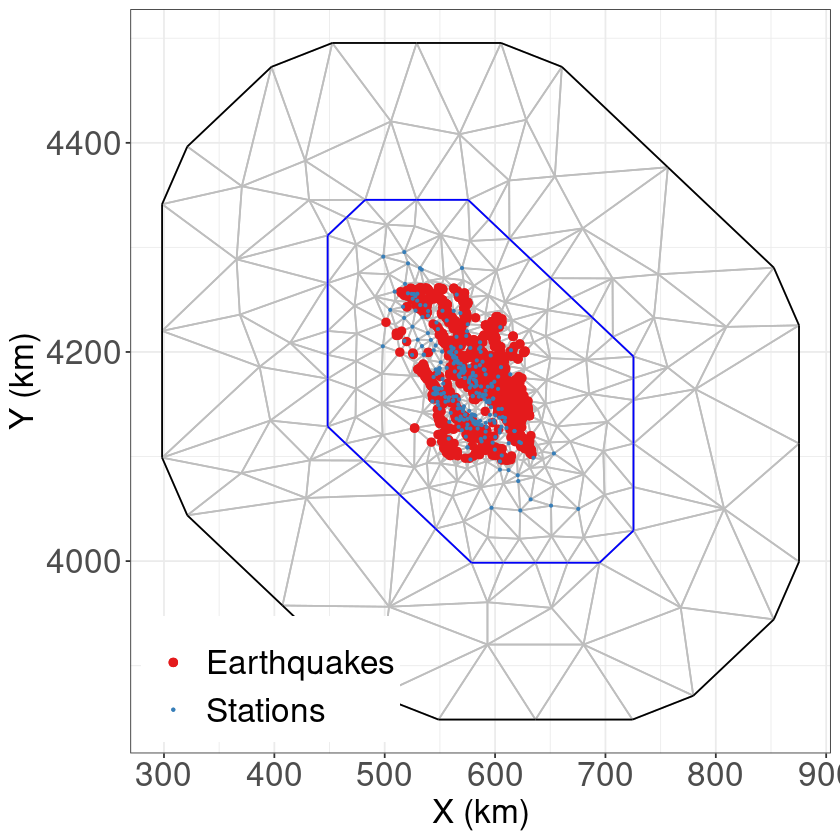

In [42]:
utm_no
# Plotting
# ---------------------------    
#plotting info
set1   <- RColorBrewer::brewer.pal(7, "Set1") #color map
#California
map_ca <- subset( map_data("state"), region %in% c("california"))
map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000
#Nevada
map_nv <- subset( map_data("state"), region %in% c("nevada"))
map_nv_utm <- LongLatToUTM(lat=map_nv$lat, lon=map_nv$long, utm_no)
map_nv[,c('X','Y')] <- map_nv_utm[,c('X','Y')]/1000
  
#Earthquake - Station Mesh
pl_mesh  <- ggplot() + theme_bw() + gg(mesh) +
              #geom_path(data=map_ca, aes(x=X,y=Y), color='black') + geom_path(data=map_nv, aes(x=X,y=Y), color='black')+
              geom_point(data=X_eq, aes(x=eqX,y=eqY, size=as.factor('EQ'), color=as.factor('EQ'))) +
              geom_point(data=X_sta, aes(x=staX,y=staY, size=as.factor('STA'), color=as.factor('STA'))) +
              scale_size_manual(values=c(2.0,0.5), labels = c('Earthquakes','Stations'), name=element_blank()) + 
              scale_color_manual(values=c(set1[1],set1[2]), labels = c('Earthquakes','Stations'), name=element_blank()) + 
              labs(x="X (km)", y="Y (km)") +
              theme(plot.title=element_text(size=20), axis.title=element_text(size=20), 
                    axis.text.y=element_text(size=20), axis.text.x=element_text(size=20),
                    legend.key.size = unit(1, 'cm'), legend.text=element_text(size=20), 
                    legend.position = c(0.20, 0.10))
print(pl_mesh)